In [17]:
# Linear data

In [75]:
import experiment
from settings.noisy_xor import get_dataloader

setting = {
    'seed': 12345,
    'input_dimension': 500, 
    'sample_size': 5000,
    'batch_size': 5000,
    'noise_rate': 0.10, 
    'within_cluster_variance': 1 / 50.,
    'clusters_per_class': 1
}

data, rotation_matrix = get_dataloader(**setting)
_, (inputs, labels) = next(enumerate(data))

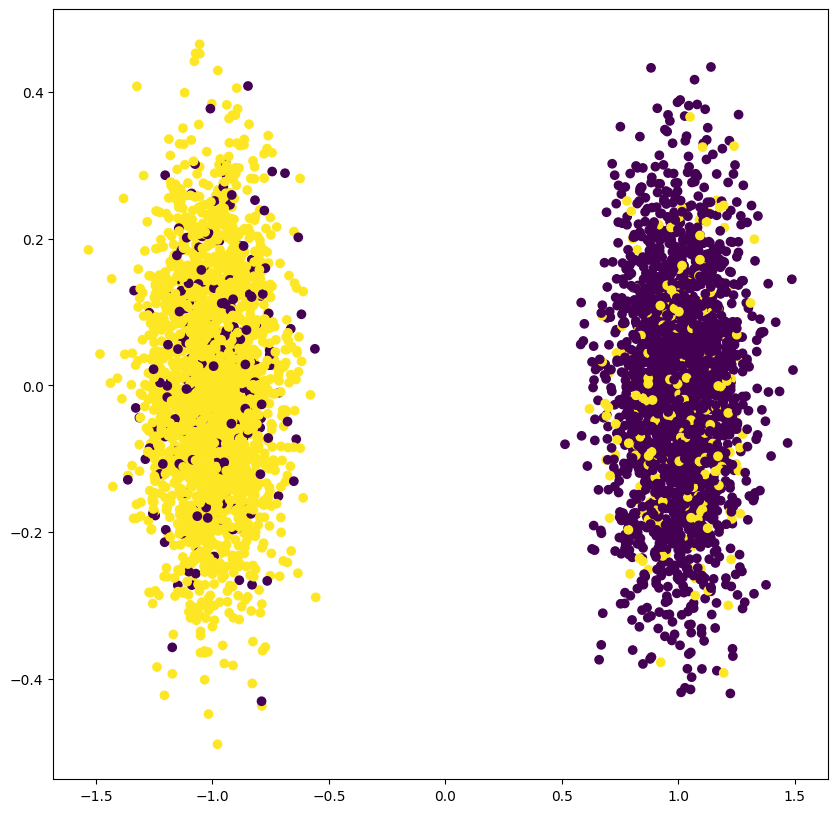

In [76]:
import numpy, matplotlib.pyplot

fig, ax = matplotlib.pyplot.subplots(figsize=(10, 10))

inputs_ = numpy.matmul(inputs.detach().cpu().numpy(), rotation_matrix.transpose())
ax.scatter(inputs_[:, 0], inputs_[:, 1], c=labels)

# Linear classifier

In [78]:
import torch
from utils.optimization import train, test, Accuracy

class LinearClassifier(torch.nn.Module):

    def __init__(self, input_dimension:int, *args, **kwargs):
        super(LinearClassifier, self).__init__()
        self.device = 'cpu'
        self.input_dimension = input_dimension
        self.linear = torch.nn.Linear(input_dimension, 1, bias=False)
        self.dummy_variable1 = torch.zeros(input_dimension, input_dimension, requires_grad=True)
        self.dummy_variable1.retain_grad()
        
    def forward(self, x):
        self.activations = x
        dummy_term1 = (x.unsqueeze(1).bmm(x.mm(self.dummy_variable1).reshape(-1, self.input_dimension, 1)).reshape(-1)).unsqueeze(1)
        output = self.linear(x) + dummy_term1
        return output

    def to(self, device):
        super().to(device)
        self.dummy_variable1 = self.dummy_variable1.to(device)
        self.dummy_variable1.retain_grad()
        self.device = device
        return self

model = LinearClassifier(**setting)

Accuracy before training: 0.6926776170730591


In [80]:
from plots import plot_samples_and_model_activation

plot_samples_and_model_activation(data, model, rotation_matrix, **setting)

AttributeError: 'LinearClassifier' object has no attribute 'input_layer'

In [ ]:

loss_fn = torch.nn.BCEWithLogitsLoss()
print(f'Accuracy before training: {test(data, model, loss_fn, model.device)}')



In [ ]:
from experiment import gradients_summary
from plots import plot_eigenspectrum

model.eval()
predictions = model(inputs)
predictions.retain_grad()
loss = loss_fn(predictions, labels)
loss.backward()
run = {}
gradients_summary(model, summary=run)
plot_eigenspectrum(run, eigenspectrum_distribution_log_scale=False)

In [ ]:
import numpy, torch, matplotlib.pyplot, experiment
from settings.concentric_spheres import get_dataset, get_dataloader

setting = {
    'input_dimension': 500, 
    'spheres_dimension': 2, 
    'sample_size': 5000,
    'margin': 0.5
}

dataset1, rotation_matrix = get_dataset(**setting, mean=torch.tensor([1., 0.]))
dataset2 = get_dataset(**setting, rotation_matrix=rotation_matrix, mean=torch.tensor([-1., 0.]))
daloader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([dataset1, dataset2]), batch_size=setting['sample_size'] * 2, shuffle=True)
_, (inputs, labels) = next(enumerate(daloader))

fig, ax = matplotlib.pyplot.subplots(figsize=(10, 10))
inputs_ = numpy.matmul(inputs.detach().cpu().numpy(), rotation_matrix.transpose())
ax.scatter(inputs_[:, 0], inputs_[:, 1], c=labels)
_ = ax.set_ylim(-2, 2)

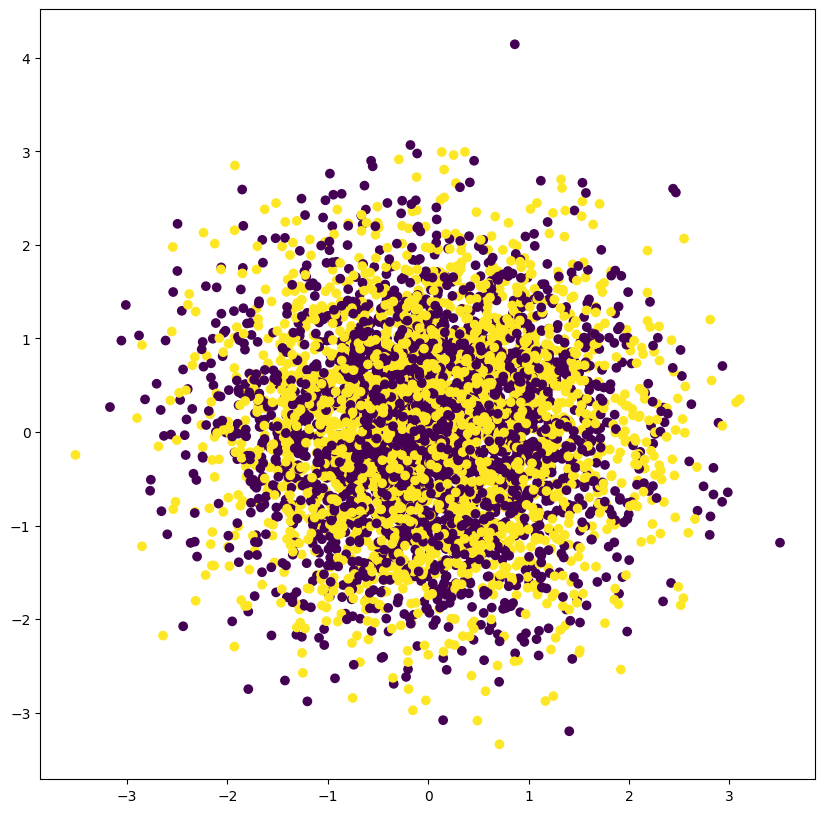

In [4]:

fig, ax = matplotlib.pyplot.subplots(figsize=(10, 10))
ax.scatter(inputs[:, 0], inputs[:, 1], c=labels)

In [9]:
inputs.shape

torch.Size([5000, 10])

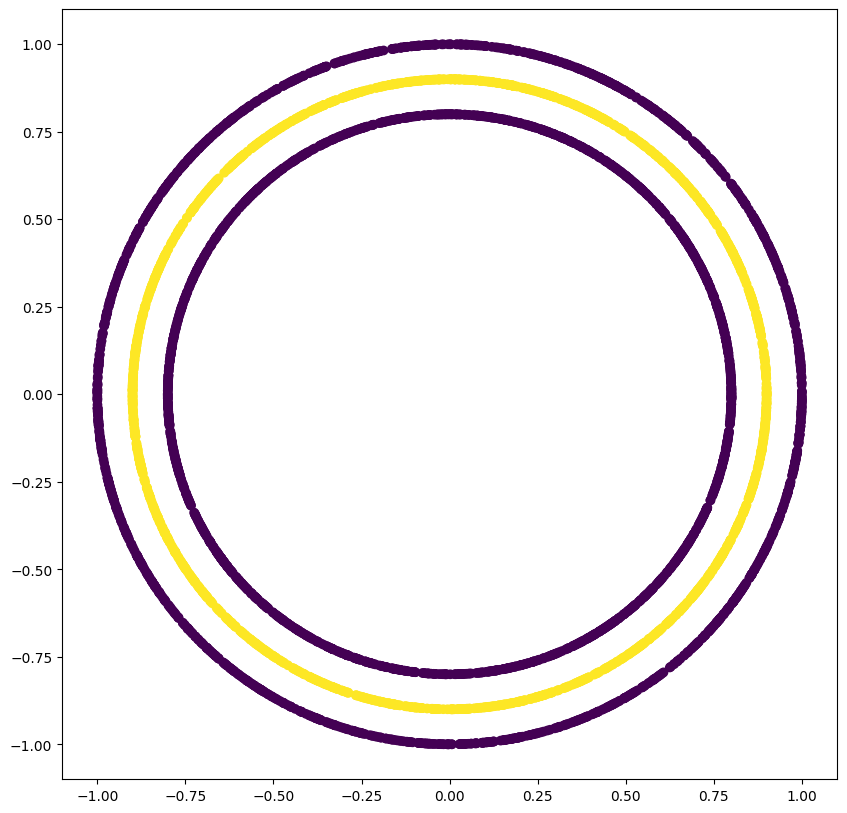

In [18]:
import numpy, matplotlib.pyplot, experiment
from settings.concentric_spheres import get_dataloader

setting = {
    'input_dimension': 500, 
    'spheres_dimension': 2, 
    'number_of_spheres': 3, 
    'sample_size': 5000
}


data, rotation_matrix = get_dataloader(**setting)
_, (inputs, labels) = next(enumerate(data))

fig, ax = matplotlib.pyplot.subplots(figsize=(10, 10))
inputs_ = numpy.matmul(inputs.detach().cpu().numpy(), rotation_matrix.transpose())
ax.scatter(inputs_[:, 0], inputs_[:, 1], c=labels)

# Linear classifier

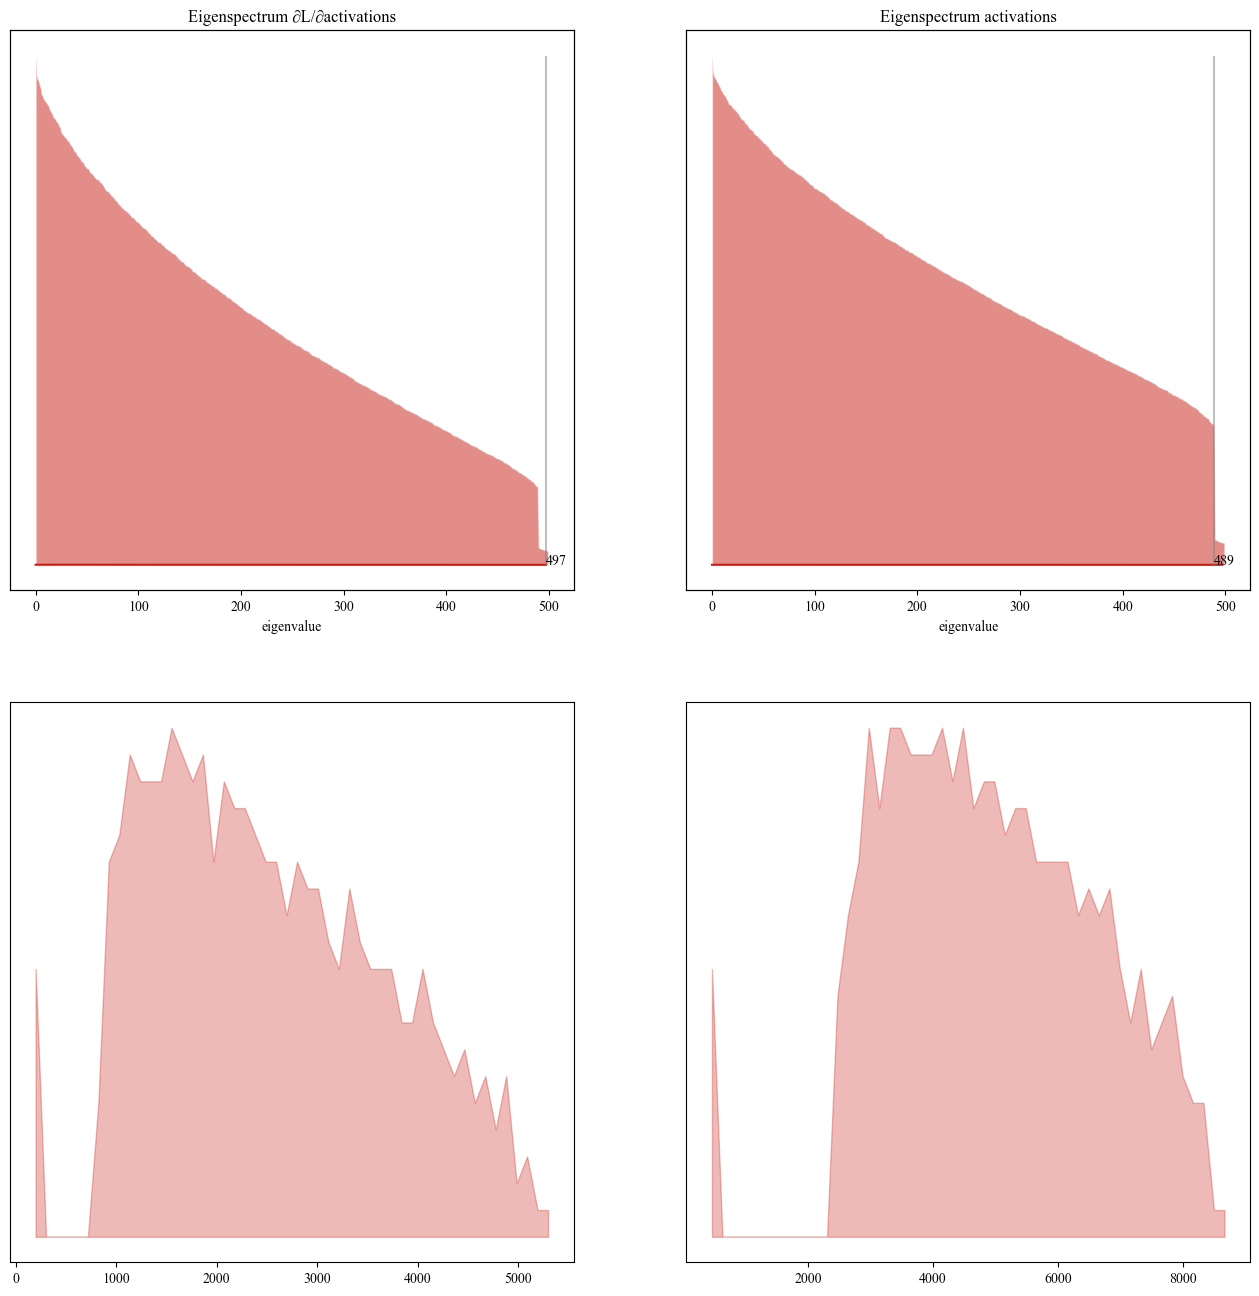

In [3]:
import numpy

from experiment import caultulate_effective_ranks
from plots import plot_eigenspectrum

inputs_ = inputs.detach().cpu().numpy()
labels_ = labels.detach().cpu().numpy()
covariance_matrix = numpy.matmul(inputs_.transpose(), inputs_)
eigenspectrum_d_L_d_sigma = sorted(numpy.abs(numpy.linalg.eigvals(numpy.matmul(inputs_.transpose(), labels_ * inputs_)).real).tolist(), reverse=True)
eigenspectrum_sigma = sorted(numpy.abs(numpy.linalg.eigvals(covariance_matrix).real).tolist(), reverse=True)

run = {
    'eigenspectrum_d_L_d_sigma': [eigenspectrum_d_L_d_sigma], 
    'r_k_d_L_d_sigma': [caultulate_effective_ranks(eigenspectrum_d_L_d_sigma)[:-1]],
    'eigenspectrum_sigma': [eigenspectrum_sigma], 
    'r_k_sigma': [caultulate_effective_ranks(eigenspectrum_sigma)[:-1]]
}

plot_eigenspectrum(run, eigenspectrum_distribution_log_scale=False)

tensor([[ 0.8839],
        [-1.1056],
        [-0.6270],
        ...,
        [ 1.3318],
        [ 0.4955],
        [ 0.4989]], grad_fn=<MmBackward0>)

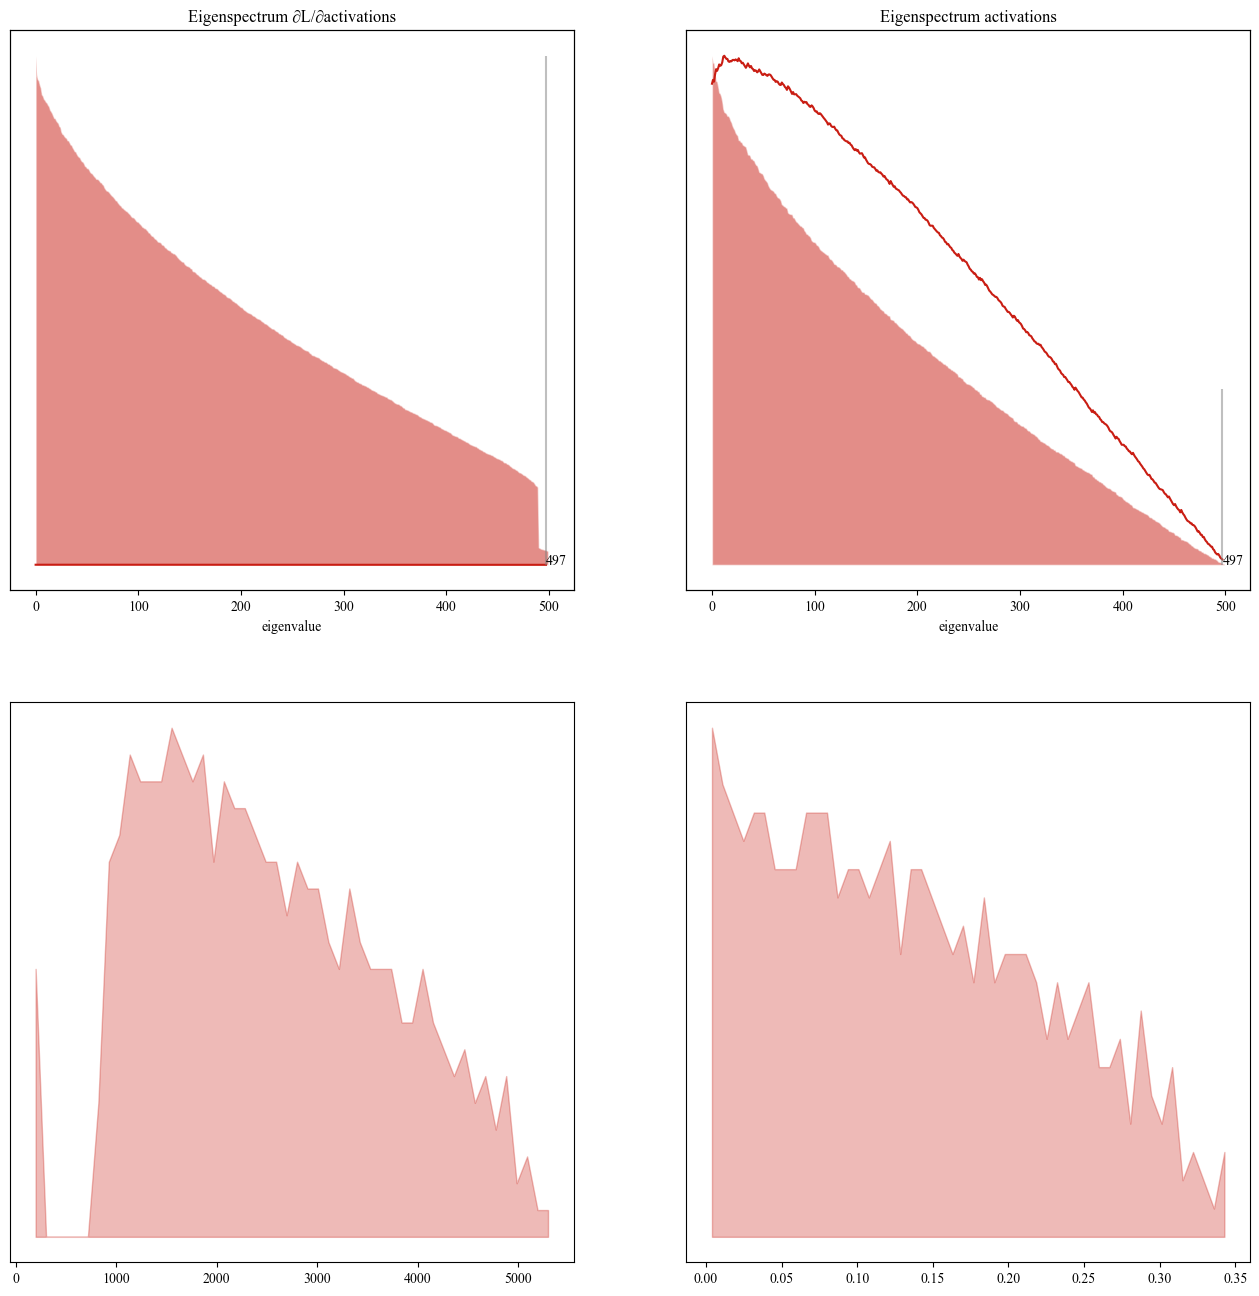

In [71]:
covariance_matrix = (((torch.nn.Sigmoid()(torch.matmul(model.activations, model.linear.weight.T)) - labels) * 1 / setting['sample_size']) * model.activations).T.mm(model.activations) 
covariance_matrix = covariance_matrix.detach().cpu().numpy()
eigenspectrum_d_L_d_sigma = sorted(numpy.abs(numpy.linalg.eigvals(numpy.matmul(inputs_.transpose(), labels_ * inputs_)).real).tolist(), reverse=True)
eigenspectrum_sigma = sorted(numpy.abs(numpy.linalg.eigvals(covariance_matrix).real).tolist(), reverse=True)

run = {
    'eigenspectrum_d_L_d_sigma': [eigenspectrum_d_L_d_sigma], 
    'r_k_d_L_d_sigma': [caultulate_effective_ranks(eigenspectrum_d_L_d_sigma)[:-1]],
    'eigenspectrum_sigma': [eigenspectrum_sigma], 
    'r_k_sigma': [caultulate_effective_ranks(eigenspectrum_sigma)[:-1]]
}

plot_eigenspectrum(run, eigenspectrum_distribution_log_scale=False)

In [58]:
labels

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [0.]])

In [53]:
predictions.grad

tensor([[ 1.4153e-04],
        [ 4.9738e-05],
        [ 6.9640e-05],
        ...,
        [ 1.5823e-04],
        [-7.5721e-05],
        [ 1.2444e-04]])

In [60]:
model.linear(model.activations)

tensor([[ 0.8839],
        [-1.1056],
        [-0.6270],
        ...,
        [ 1.3318],
        [ 0.4955],
        [ 0.4989]], grad_fn=<MmBackward0>)

In [37]:
predictions

tensor([[ 0.3854],
        [-0.0534],
        [-0.1758],
        ...,
        [ 0.0403],
        [-1.0879],
        [ 0.1614]], grad_fn=<AddBackward0>)

In [8]:
model.activations.t().mm(model.activations)

tensor([[4804.5449,  -56.5412,   39.7912,  ...,  -53.2759,  -21.7399,
          -84.7131],
        [ -56.5412, 4827.6646,  -23.7163,  ...,  169.3740,   81.5580,
          -37.4652],
        [  39.7912,  -23.7163, 4826.7861,  ..., -101.5934,   69.5729,
         -141.5643],
        ...,
        [ -53.2759,  169.3740, -101.5934,  ..., 4717.2280,  -57.8921,
           14.0931],
        [ -21.7399,   81.5580,   69.5729,  ...,  -57.8921, 5000.1865,
          -16.1915],
        [ -84.7131,  -37.4652, -141.5643,  ...,   14.0931,  -16.1915,
         5015.2104]])

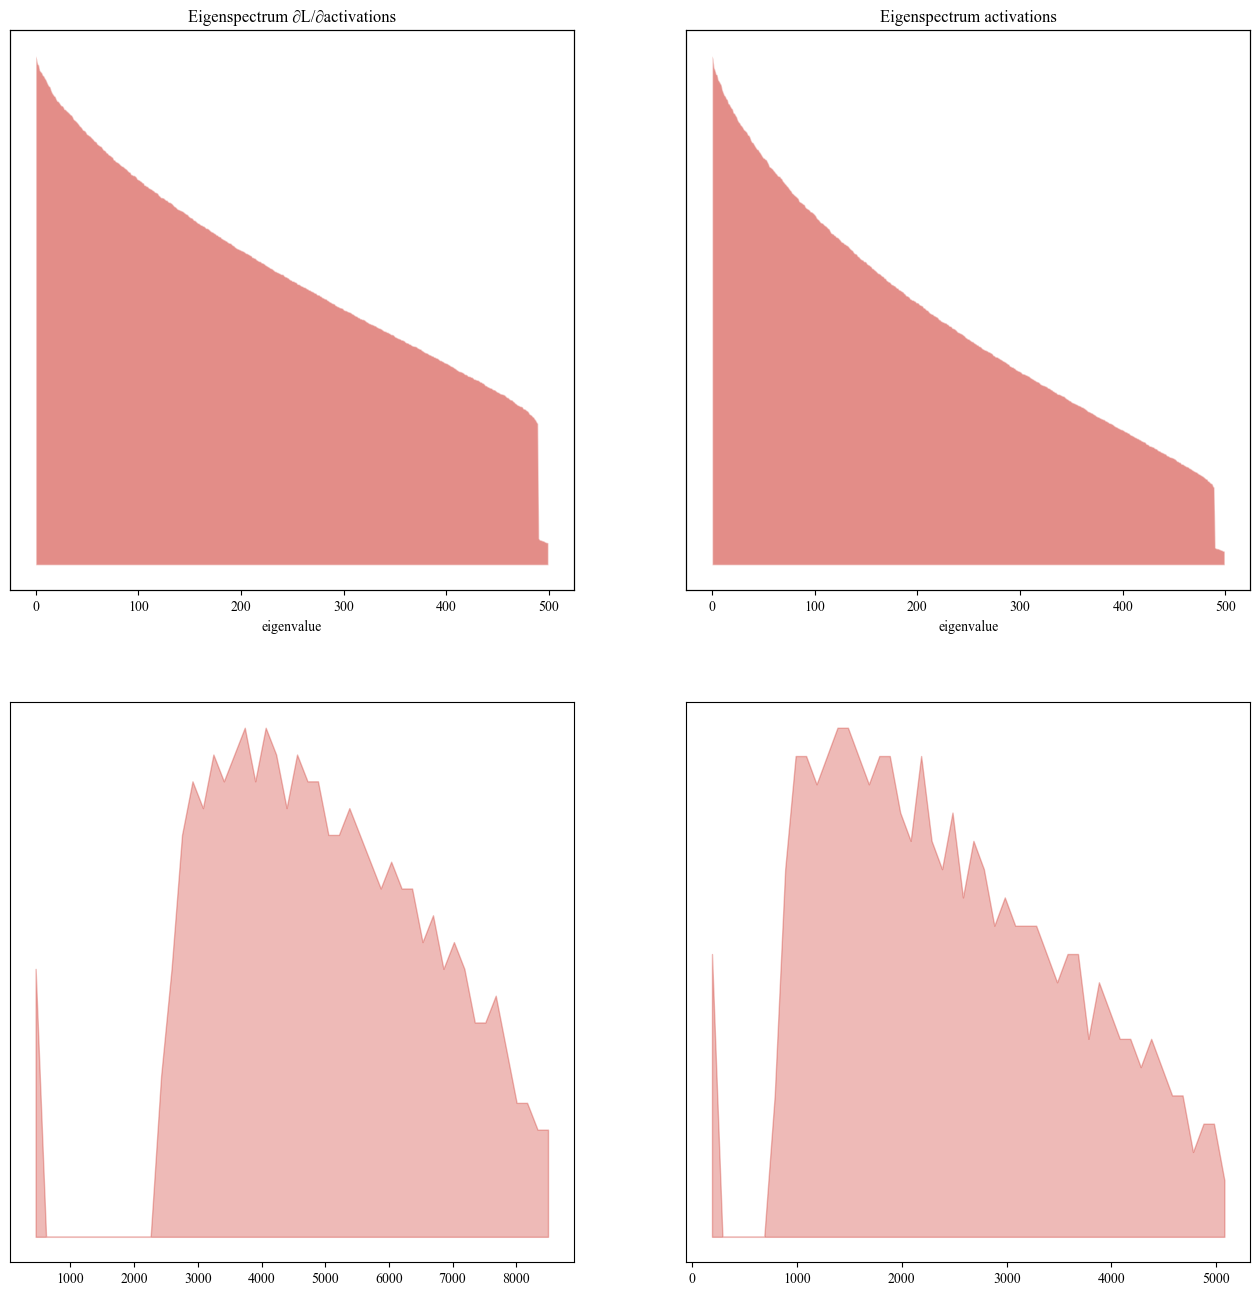

In [14]:
len(eigenspectrum_d_L_d_sigma)

500

In [1]:
import ipycanvas

training_canvas, ranks_canvas, input_domain_canvas = ipycanvas.Canvas(), ipycanvas.Canvas(), ipycanvas.Canvas()
training_canvas.width = training_canvas.height = 1000
ranks_canvas.width = ranks_canvas.height = 1600
input_domain_canvas.width = input_domain_canvas.height = 600
training_canvas.font = ranks_canvas.font = input_domain_canvas.font = "30px arial"
args = ('Results will appear as processed', training_canvas.width / 4, training_canvas.height / 3)
training_canvas.fill_text(*args); ranks_canvas.fill_text(*args); input_domain_canvas.fill_text(*args)

In [2]:
training_canvas

Canvas(height=1000, width=1000)

In [3]:
ranks_canvas

Canvas(height=1600, width=1600)

In [4]:
input_domain_canvas

Canvas(height=600, width=600)

In [6]:
from experiment import execute_experiment
from plots import plot_eigenspectrum_on_canvas, plot_samples_and_model_activation_on_canvas

experiment_results = execute_experiment(
    seed=12345,
    input_dimension=2,
    sample_size=5000,
    batch_size=5000,
    epochs=1000,
    learning_rate=0.05,
    hidden_units=500,
    bias=False,
    margin=0.5,
    save_models_path='./models/',
    save_experiments_path='./experiments/',
    saving_epochs_interval=100,
    plot_results_on_canvas=training_canvas,
    callbacks=[
        plot_eigenspectrum_on_canvas(ranks_canvas), 
        plot_samples_and_model_activation_on_canvas(input_domain_canvas)
    ]
)

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
stop

In [ ]:
import numpy, torch, matplotlib.cm

from experiment import TwoLayerNeuralNet, gradients_summary
from settings.concentric_spheres import get_dataloader
from utils.optimization import Accuracy, initialize
from plots import plot_samples_and_model_activation
from utils.persistance import parameters_from_file_path
experiment_results = dict(
    seed=12345,
    input_dimension=2,
    sample_size=5000,
    batch_size=5000,
    epochs=1000,
    learning_rate=0.05,
    hidden_units=500,
    bias=False,
    margin=0.5,
    save_models_path='./models/',
    save_experiments_path='./experiments/',
    saving_epochs_interval=100,)

initialize(experiment_results['seed'])

data = get_dataloader(**experiment_results)
_, (inputs, labels) = next(enumerate(data))

model = TwoLayerNeuralNet.load('./models/', **experiment_results)
predictions = model(inputs)
print(f'Train accuracy: {Accuracy(predictions, labels)}')

fig = plot_samples_and_model_activation(data, model, experiment_results['input_dimension'])
[ax] = fig.axes

loss = torch.nn.BCEWithLogitsLoss()(predictions, labels)
loss.backward()

outer_product_d_L_d_sigma = model.dummy_variable1.grad.detach().cpu().numpy()
eigvals, eigvecs = numpy.linalg.eig(outer_product_d_L_d_sigma)
eigvals = abs(eigvals.real)
eigvecs = numpy.array(list(map(lambda x: x[1], sorted(zip(eigvals, eigvecs.real.transpose()), key=lambda x: x[0], reverse=True))))
eigvals = sorted(eigvals, reverse=True)
r_k = [sum(eigvals[k:]) / eigenvalue for k, eigenvalue in enumerate(eigvals[:-1]) if eigenvalue > 0][:-1]
k_star = r_k.index(min(r_k))

eigvecs_weights = numpy.matmul(eigvecs, model.input_layer.weight.data.detach().cpu().numpy())
#eigvecs_biases = numpy.matmul(eigvecs[:k_star], model.input_layer.bias.data.detach().cpu().numpy()).tolist()
colors = matplotlib.cm.OrRd_r(numpy.linspace(.2, .6, len(eigvecs_weights)))
for eigenvector, color in zip(eigvecs_weights, colors):
    ax.arrow(0, 0, *eigenvector, color=color)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
#fig

In [ ]:
from experiment import gradients_summary
run = {}
gradients_summary(model, summary=run)

In [ ]:
from plots import plot_eigenspectrum

plot_eigenspectrum(run, 0)

In [ ]:
import matplotlib.pyplot
matplotlib.pyplot.gcf()